# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [681]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Open the training and validation datasets.

In [714]:
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

### Importar Images

Generate the training and validation datasets, without the label to predict.

In [715]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']

In [716]:
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

Split the validation entire data set in to test and validation.

In [717]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    """
    Splits the input data (x, y) into validation and test sets based on a specified percentage.

    If shuffle is True, the data is shuffled before splitting. The split is done by taking 
    the first portion of the data as the validation set and the remaining portion as the test set.
    """
    if shuffle:
        indices = np.arange(x.shape[0])
        np.random.shuffle(indices)
        x = x[indices]
        y = y[indices]

    split_index = int((1 - pct) * len(x))

    x_val, x_test = x[:split_index], x[split_index:]
    y_val, y_test = y[:split_index], y[split_index:]

    return x_val, y_val, x_test, y_test

In [718]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

Because of the movement nature of the J and Z letters, remove them.

In [719]:
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')

In [710]:
assert 24 == len(alphabet)

### Normalise

In [688]:
def normalise(x_mean, x_std, x_data):
    """
    Normalizes the input data by subtracting the mean and dividing by the standard deviation.
    """
    return (x_data - x_mean) / x_std

Calculate the average and standard deviation from the normalized datasets.

In [689]:
x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

the standard deviation is almost perfect

In [690]:
x_train.mean(), x_train.std()

(np.float32(3.6268384e-06), np.float32(0.99999946))

### Graficar muestras

In [726]:
def plot_image(image):
  """
  Simple display of a given image in gray scale.
  """
  plt.figure(figsize=(5, 5))
  plt.imshow(image.reshape(28, 28), cmap=plt.get_cmap('gray'))
  plt.axis('off')
  plt.show()

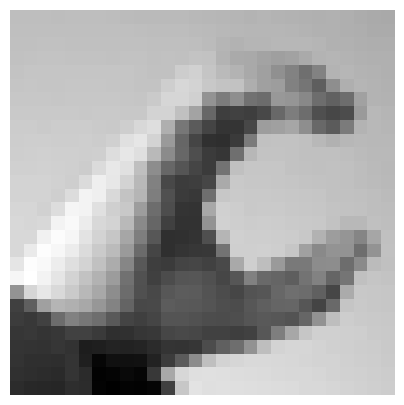

Displaying: c


In [741]:
# Let's jsut print a random image to see if it works...
rnd_idx = np.random.randint(len(y_test))
plot_image(x_test[rnd_idx])
actual_char = alphabet[y_test[rnd_idx]]
print(f"Displaying: {actual_char}")

### Math ecuations for the model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Utility functions

#### Mini batches

In [693]:
def create_minibatches(mb_size, x, y, shuffle = True):
    """
    Creates minibatches from the input data (x, y) by splitting them into smaller batches of a specified size.

    If shuffle is True, the data is shuffled before creating minibatches.
    """
    assert x.shape[0] == y.shape[0], 'Error: number of samples do not match'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

###  Clase Linear

Tensor class with `ndarray` properties via inheritance.

In [711]:
class np_tensor(np.ndarray): pass

Create the fully connected layer of the linear neural network that streamline the layers passed as parameters.

In [712]:
class Linear():
    """
    A class representing a linear layer in a neural network. 

    It initializes the weights and biases, performs the forward pass, 
    and computes the gradients during the backward pass.
    """
    def __init__(self, input_size, output_size):
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    def __call__(self, X):
        Z = self.W @ X + self.b
        return Z

    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    


### Activation function

Simple implementation the Rectified Linear Unit activation function.

In [696]:
class ReLU():
    """
    A class representing the ReLU activation function.

    It applies the ReLU function during the forward pass and computes the gradient during the backward pass.
    """
    def __call__(self, Z):
        return np.maximum(0, Z)

    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Sequential layer class

In [697]:
class Sequential_layers():
    """
    A class that represents a sequence of layers in a neural network.

    It handles the forward pass, backward pass, weight updates, and predictions by chaining multiple layers.
    """
    def __init__(self, layers):
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x

    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad

    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost function

In [698]:
def softmaxXEntropy(x, y):
    """
    Computes the softmax activation followed by the cross-entropy loss.

    It also calculates the gradient of the loss with respect to the input (x) for backpropagation.
    """
    batch_size = x.shape[1]
    exp_scores = np.exp(x)

    probs = exp_scores / exp_scores.sum(axis=0)
    preds = probs.copy()

    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size

    probs[y.squeeze(), np.arange(batch_size)] -= 1
    x.grad = probs.copy()

    return preds, cost

### Training loop

In [699]:
def train(model, epochs, mb_size=128, learning_rate=1e-3):
  """
  Trains the model for a specified number of epochs using minibatches.

  For each minibatch, it performs a forward pass, computes the loss, performs backpropagation, 
  and updates the model's parameters. After each epoch, the current cost and accuracy are printed.
  """
  for epoch in range(epochs):
    for i, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x_train, y_train)):
      scores = model(x_batch.T.view(np_tensor))
      _, cost = softmaxXEntropy(scores, y_batch)

      model.backward()
      model.update(learning_rate)

    print(f'Epoch {epoch+1}, Cost: {cost}, Accuracy: {accuracy(x_val, y_val, mb_size)}')


In [700]:
def accuracy(x, y, mb_size):
  """
  Calculates the accuracy of the model by comparing predictions to true labels.

  It computes the percentage of correct predictions over the total number of samples.
  """
  correct, total = 0, 0

  for _, (x_batch, y_batch) in enumerate(create_minibatches(mb_size, x, y)):
    pred = model(x_batch.T.view(np_tensor))
    correct += np.sum(np.argmax(pred, axis=0) == y_batch.squeeze())
    total += pred.shape[1]

  return correct / total

### Create your model and train it

Input variables, using standard power of 2 number for the batching-size (although not really needed).

In [701]:
mb_size = 512
learning_rate = 1e-3
epochs = 30

Make the input size the same length as the image pixels, one neuron per pixel in the hidden layer

In [702]:
input_size = 784
layer_size = 784
output_size = 24

Model architecture that include the previous formulas with the input, outputs and hyperparameters.

In [703]:
model = Sequential_layers([
  Linear(input_size, layer_size),
  ReLU(),
  Linear(layer_size, layer_size),
  ReLU(),
  Linear(layer_size, output_size)
])

Notes:
- mb size: 512 well enough
- learning rate: this was the fastest but more accurate time learning rate
- epoch: 30 gave us enogh room to get an 80% accuracy
- input and layer size: both are the same so we can max out the input for all with the flattened grayscale image 
- output size: 24 as 24 letter of the alphabet

The chosen architecture and hyperparameters are well-suited for training on the dataset efficiently and effectively. A mini-batch size of 512 provides a balance between computational efficiency and stable gradient updates, while the learning rate was selected as the fastest value ensuring convergence without sacrificing accuracy. 

Training for 30 epochs allowed the model to achieve approximately 80% accuracy without overfitting.


The input size matches the flattened grayscale image dimensions, ensuring all features are fully utilized, and the layer size matches the input size to maximize learning capacity across layers.

The output size of 24 corresponds to the number of alphabet letters, enabling direct classification. 

The architecture consists of an initial `Linear` layer to map the input to a meaningful feature space, followed by `ReLU` activation for non-linear transformations, a second `Linear` layer to refine these features, another `ReLU` for preserving non-linearity, and a final `Linear` layer to map the processed features to 24 output classes. 

### Test your model on random data from your test set

Start the training loop for 30 epochs.

In [704]:
train(model, epochs, mb_size, learning_rate)

Epoch 1, Cost: 0.1149689171703088, Accuracy: 0.783324037925265
Epoch 2, Cost: 0.01524977743754943, Accuracy: 0.805633017289459
Epoch 3, Cost: 0.008967209057028679, Accuracy: 0.8053541550474066
Epoch 4, Cost: 0.006548908352766799, Accuracy: 0.8081427774679308
Epoch 5, Cost: 0.0044889518301248375, Accuracy: 0.8087005019520357
Epoch 6, Cost: 0.003535997182632247, Accuracy: 0.8112102621305075
Epoch 7, Cost: 0.003097835907069203, Accuracy: 0.8120468488566648
Epoch 8, Cost: 0.0022740561684846264, Accuracy: 0.8120468488566648
Epoch 9, Cost: 0.002243483888049497, Accuracy: 0.8131622978248745
Epoch 10, Cost: 0.0019400243815978085, Accuracy: 0.8153931957612939
Epoch 11, Cost: 0.0016769557221001583, Accuracy: 0.8153931957612939
Epoch 12, Cost: 0.001352817788030561, Accuracy: 0.8179029559397658
Epoch 13, Cost: 0.0011376726262969593, Accuracy: 0.8187395426659231
Epoch 14, Cost: 0.0011637961370423611, Accuracy: 0.8192972671500279
Epoch 15, Cost: 0.001030888746933828, Accuracy: 0.82069157836029
Epoch

Calculate the total accuracy of the model.

In [705]:
print(f"Test Accuracy: %{accuracy(x_test, y_test, mb_size) * 100}")

Test Accuracy: %81.31622978248745


For displaying the result, standarize the making all the chars lower case and removing j and z letters again (as the model won't include for those two letters).

In [706]:
alphabet = list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')

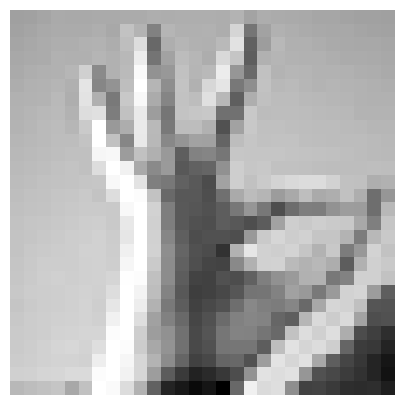

Predicted label: f, Actual label: f


In [ ]:
idx = np.random.randint(len(y_test))

plot_image(x_test[idx])

pred = model.predict(x_test[idx].reshape(-1, 1))
pred_char = alphabet[pred]
actual_char = alphabet[y_test[idx]]

print(f"Predicted label: {pred_char}, Actual label: {actual_char}")